# Contours
Contours are curves that define the boundaries of objects in an image. In image processing, contours are often used to segment and analyze objects in an image.

Contours can be detected in images using various image processing techniques, such as _edge detection_, _thresholding,_ and _morphological_ operations.

Contours are a fundamental concept in image processing, and they are widely used in a variety of applications, such as object recognition, image segmentation, and computer vision.

# Morphological Closing
Morphological closing is a type of image processing operation that is used to smooth or close small holes and gaps in objects in an image or remove noise in an image.  It is a _dilation_ followed by an _erosion_, and it is often used to clean up or pre-process images before applying other image processing techniques, such as **thresholding** or **edge detection**.

_Dilation_ is a morphological operation that expands the shape of an object in an image by adding pixels around the object. It is often used to fill in small gaps or holes in the object.

_Erosion_ is a morphological operation that shrinks the shape of an object in an image by removing pixels from the object. It is often used to thin or skeletonize the object.

**References**
- Some of my code and concepts was found here: https://learnopencv.com/automatic-document-scanner-using-opencv/#References--
- Image was copied from here: https://expressexpense.com/blog/free-receipt-images-ocr-machine-learning-dataset/

**Usecase**: Having a picture of a receipt and use an OCR for understanding it. I've started that yesterday at Day 04 of my 100DaysOfCode challenge. Today I will use contour detection techniques for being able to scan a receipt and rearrange it for helping Tesseract to understand the text.

In [1]:
import cv2
import imutils
import pytesseract
import numpy as np

from PIL import Image

## Imperative Scripting style

In [27]:
def display_image(cv2_image, factor):
    """
    Display an image using a given scaling factor.
    This method was created for having nicer inline
    vizualizations for big images in Jupyter-Notebooks

    Parameters
    ----------
    cv2_image : ndarray
        The image to display, as a numpy array.
    factor : float
        The scaling factor to apply to the image.

    Returns
    -------
    None
    """
    # Get the current width and height of the image
    width, height = cv2_image.shape[:2]

    new_width = int(width * factor)
    new_height = int(height * factor)
    img = cv2.resize(cv2_image, (new_width, new_height))
    img = Image.fromarray(img)

    display(img)

In [44]:
# The original image should not get mutated
# at any futured line of code!
original_image = cv2.imread("./receipt.jpg")

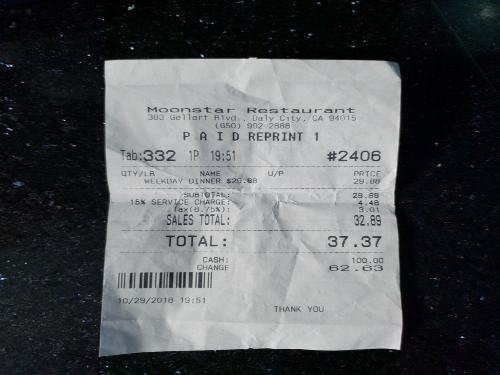

In [45]:
display_image(original_image, 0.5)

Let's Check what PyTesseract does with that image without rearrange it

In [46]:
text = pytesseract.image_to_string(original_image)

In [47]:
print(text)

Sis: ae
Pep: yh \ 37.37

wu




**That's a bad result! Let's check if it's possible to rearrange that image for having better results**

In [49]:
# Morphological Closing
kernel = np.ones((5,5),np.uint8)
morphology = cv2.morphologyEx(original_image, cv2.MORPH_CLOSE, kernel, iterations= 3)

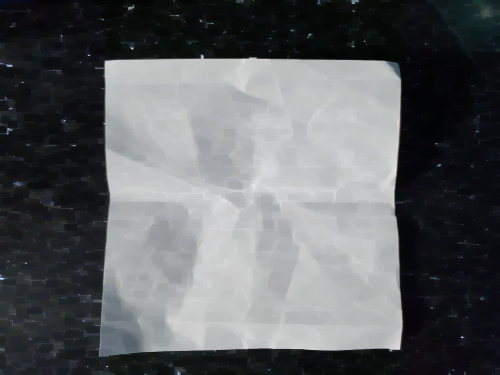

In [50]:
display_image(morphology, 0.5)

In [107]:
# This task is pretty expensive compared to the tasks before!

# Region of Interest `ROI`
# Define the initial ROI as a rectangle with top-left corner at (1, 1)
# and dimensions of the input image
roi = (20, 20, morphology.shape[1]-40, morphology.shape[0]-40)

# Create a zero array with the same shape as the input image, but with a data type of np.uint8
mask = np.zeros(morphology.shape[:2], np.uint8)

# Define the background and foreground models
bgd_model = np.zeros((1, 65), np.float64)
fgd_model = np.zeros((1, 65), np.float64)

# Perform the GrabCut algorithm on the input image, using the mask, initial ROI, and background/foreground models
iterations = 5
cv2.grabCut(morphology, mask, roi, bgd_model, fgd_model, iterations, cv2.GC_INIT_WITH_RECT)

# Create a new mask by setting all "probably foreground" pixels to 1 and all other pixels to 0
# mask = (mask == 2).astype(np.uint8)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')

# Apply the mask to the input image by setting all masked pixels to 0
cutted_img = morphology * mask2[:,:,np.newaxis]

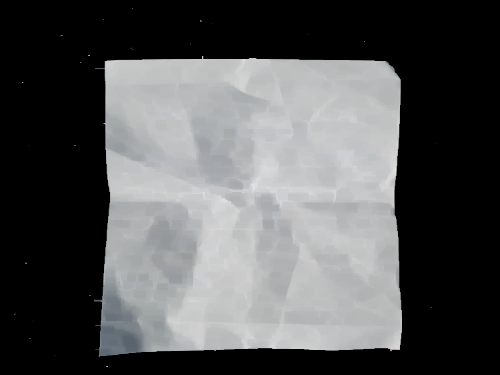

In [108]:
display_image(cutted_img, 0.5)

In [109]:
# Grayscaling an image can be useful for image processing tasks because it reduces
# the complexity of the image. When an image is grayscale, it has only one channel
# (intensity values) instead of three channels (red, green, and blue).

# In addition, grayscaling an image can sometimes improve the performance of image
# processing algorithms. For example, certain edge detection algorithms may work
# better on grayscale images, because they can focus on the intensity values of the
# image rather than being influenced by the color channels. 

# On Top: Some algorithms only work on grayscaled images.


gray_scaled_image = cv2.cvtColor(cutted_img, cv2.COLOR_BGR2GRAY)

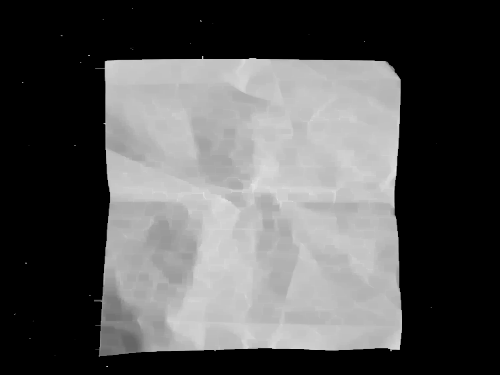

In [110]:
display_image(gray_scaled_image, 0.5)

In [119]:
# Note - a good bluring is important for having good results.
# I was try and error for the value `(21, 21)`
blured_image = cv2.GaussianBlur(gray_scaled_image, (13, 13), 0)

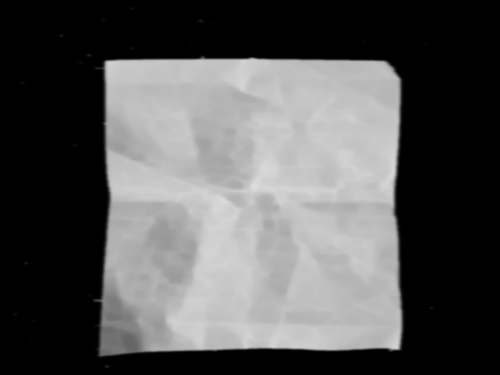

In [120]:
display_image(blured_image, 0.5)

In [121]:
canny = cv2.Canny(blured_image, 0, 200)
edges = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

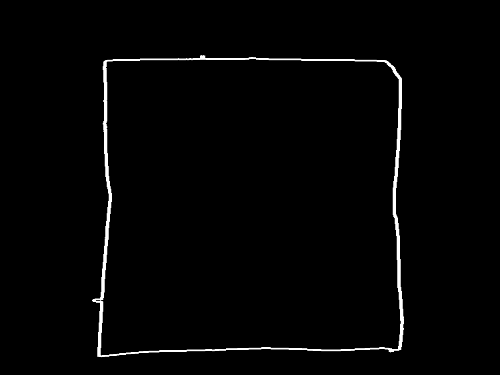

In [122]:
display_image(edges, 0.5)

In [123]:
# Create a blank canvas with the same shape and data type as the input image
blank_canvas = np.zeros_like(original_image)

# Find the contours in the edge-detected image and their hierarchy
contours, hierarchy = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

# Sort the contours by area in descending order and keep the top num_contours largest contours
num_contours = 5
top_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:num_contours]

# Draw the top num_contours contours on the blank canvas
image_with_contours = cv2.drawContours(blank_canvas, top_contours, -1, (0, 255, 255), 3)

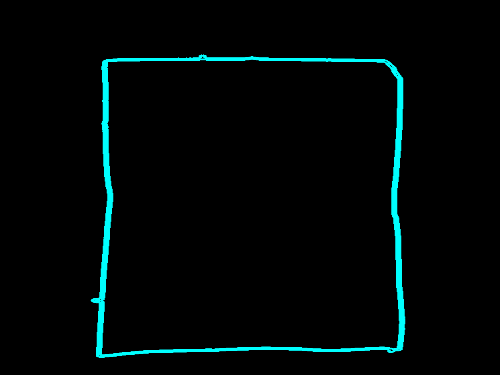

In [124]:
display_image(image_with_contours, 0.5)

In [125]:
# Create a blank canvas with the same shape and data type as the input image
blank_canvas = np.zeros_like(original_image)

# Loop over the contours.
for contour in top_contours:
    # Approximate the contour.
    epsilon = 0.02 * cv2.arcLength(contour, True)
    corners = cv2.approxPolyDP(contour, epsilon, True)
    # If our approximated contour has four points
    if len(corners) == 4:
        break

cv2.drawContours(blank_canvas, contour, -1, (0, 255, 255), 3)
cv2.drawContours(blank_canvas, corners, -1, (0, 255, 0), 20)
# Sorting the corners and converting them to desired shape.
corners = sorted(np.concatenate(corners).tolist(), key=lambda point: point[0])
 
# Displaying the corners.
for index, c in enumerate(corners):
    character = chr(65 + index)
    cv2.putText(blank_canvas, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2, cv2.LINE_AA)

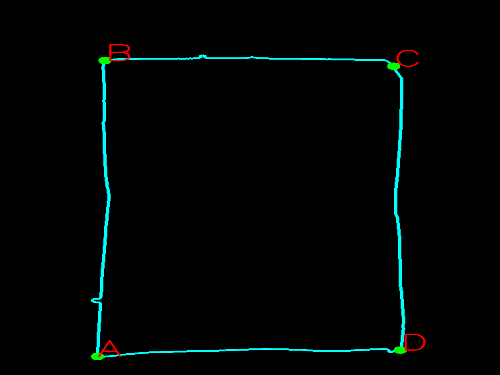

In [126]:
display_image(blank_canvas, 0.5)

In [127]:
def order_points(pts):
    """
    Rearrange coordinates to order:
    top-left, top-right, bottom-right, bottom-left
    """
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]
 
    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # Return the ordered coordinates.
    return rect.astype('int').tolist()

In [128]:
(tl, tr, br, bl) = corners
# Finding the maximum width.
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))
# Finding the maximum height.
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))
# Final destination co-ordinates.
destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]

In [130]:
# Getting the homography.
M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
# Perspective transform using homography.
final = cv2.warpPerspective(
    original_image, M, (destination_corners[2][0], destination_corners[2][1]), flags=cv2.INTER_LINEAR
)

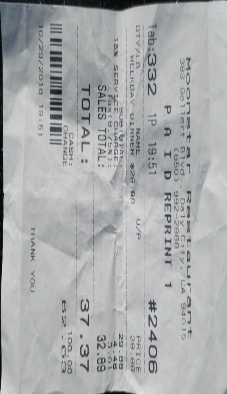

In [131]:
display_image(final, 0.5)

In [132]:
rotated_image = imutils.rotate_bound(final, 270)

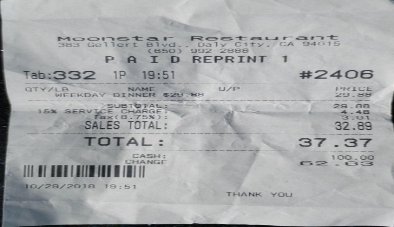

In [133]:
display_image(rotated_image, 0.5)

In [134]:
text = pytesseract.image_to_string(rotated_image)

In [135]:
print(text)

Moonstar Restaurant
383 Gellert Blvd., Daly City, CA 94015
(650) 992-2888

PAID REPRINT 1

18:332 1 1841 #2406
ava ME UP PRICE
WEEKDAY DINNER $29-88 29.88
~/SuBTPTAK: |) 23.88

15% me: CHARGES. My 4.48
8.75K): 3.01

© Sis Th: a ae
ol: Sh 37.37

ie

0/28/2018 19:5)

THANK YOU




This result is still not perfect, but better than before.
It was hard to adjust the parameters for being able to get this result.